# Triage Issue

* This is a helper notebook to go with the triage module
* The notebook serves the following purposes
  1. It can be used to generate plots showing how well the Kubeflow project is doing triaging issues in a timely fashion
  1. It provides snippets of code that can be executed to triage issues
  1. It provides snippets of code that can be used to collect some of the information needed by the code
* Issues needing Triage are added to the [Needs Triage Project](https://github.com/orgs/kubeflow/projects/26)
  * Kubeflow maintainers can look at the Kanban board to identify issues needing triage and triage them

## Setup

* The cells below import required libraries and do some other housekeeping

In [1]:
import matplotlib
import importlib
import logging
import sys
import os
import datetime
from dateutil import parser as dateutil_parser
import glob
import json
import numpy as np
import pandas as pd
# A bit of a hack to set the path correctly
sys.path = [os.path.abspath(os.path.join(os.getcwd(), ".."))] + sys.path

logging.basicConfig(level=logging.INFO,
                  format=('%(levelname)s|%(asctime)s'
                        '|%(message)s|%(pathname)s|%(lineno)d|'),
                datefmt='%Y-%m-%dT%H:%M:%S',
                )
logging.getLogger().setLevel(logging.INFO)

In [241]:
%matplotlib inline

In [242]:
import code_intelligence
from code_intelligence import graphql
from code_intelligence import triage
importlib.reload(triage)

<module 'code_intelligence.triage' from '/home/jlewi/git_code-intelligence/py/code_intelligence/triage.py'>

In [243]:
client = graphql.GraphQLClient()

## Download Issues

* The cells below use GitHub's GraphQL API to download all issues in a specified repository that have been updated since `start_time`
* The downloaded issues are stored in `.data`; this makes it easy to rerun the processing without needing to redownload the issues

In [244]:
today = datetime.datetime.now()
today = datetime.datetime(year=today.year, month=today.month, day=today.day)

start_time = today - datetime.timedelta(weeks=24)

In [245]:
issue_filter = {
    "since": start_time.isoformat(),
}
start_time_day =  start_time.strftime("%Y%m%d")
repo = "kubeflow/kubeflow"
issues_dir = os.path.join(os.getcwd(), ".data", "issues", repo, start_time_day)

if os.path.exists(issues_dir):
    logging.info("Issues data already exists; not redownloading")
else:    
    triager = triage.IssueTriage()
    try:        
        triager.download_issues(repo, issues_dir)
    except Exception as download_error:
        raise

INFO:root:kubeflow/kubeflow has a total of 1100 issues
INFO:root:initializing the shard writer
INFO:root:Wrote shard 0
INFO:root:Wrote shard 1
INFO:root:Wrote shard 2
INFO:root:Wrote shard 3
INFO:root:Wrote shard 4
INFO:root:Wrote shard 5
INFO:root:Wrote shard 6
INFO:root:Wrote shard 7
INFO:root:Wrote shard 8
INFO:root:Wrote shard 9
INFO:root:Wrote shard 10


## Compute Triage Stats

* The cells below compute a time series indicating the number of untriaged issues as a function of time
* The graph is used to determine whether the backlog of untriaged issues is increasing or decreasing

In [246]:
shard_files = glob.glob(os.path.join(issues_dir, "*.json"))

def init_df(offset=0, size=300):
    """Initialize a dataframe of the specified size."""
    return pd.DataFrame({
        "time": [datetime.datetime.now()] * size,
        "delta": np.zeros(size),
    }, index=offset + np.arange(size))


def init_issue_df(offset=0, size=300):
    return pd.DataFrame({
        "created_at": [datetime.datetime(year=2050, month=1, day=1)] * size,
        "triaged_at": [datetime.datetime(year=2050, month=1, day=1)] * size,
        "closed": [bool] * size,
        "url": [""] * size,
        "needs_triage": [bool] * size,
    }, index=offset + np.arange(size))
    
    
def grow_df(df, offset=0, size=300):
    return pd.concat([df, init_df(offset, size)])

num_issues = 0

triage_stats = init_df(size=len(shard_files) * 100 * 2)
issues_df = init_issue_df(size=len(shard_files) * 100)

issues_index = 0

for f in shard_files:
    logging.info("Processing %s", f)
    with open(f) as hf:
        issues = json.load(hf)

    delta = 2 * len(issues)
    if num_issues + delta  > triage_stats.shape[0]:
        # Grow the dataframe
        triage_stats = grow_df(triage_stats, offset=triage_stats.shape[0], size=delta)

    
    if issues_index + len(issues) > issues_df.shape[0]:
        issues_df = grow_df(issues_df, offset= issues_df.shape[0], size=len(issues))    

    for i in issues:        
        info = triage.TriageInfo.from_issue(i)
        
        create_time = dateutil_parser.parse(info.issue["createdAt"])
        
        issues_df["created_at"].at[issues_index] = create_time
        issues_df["url"].at[issues_index] = info.issue["url"]
        issues_df["needs_triage"].at[issues_index] = info.needs_triage
        
        if not info.needs_triage and not info.triaged_at:
            raise ValueError("Issue doesn't need triage but triaged at time not set")
        if info.triaged_at:
            issues_df["triaged_at"].at[issues_index] = info.triaged_at            

        if info.closed_at:
            issues_df["closed"].at[issues_index] = True
        else:
            issues_df["closed"].at[issues_index] = False
        issues_index += 1


issues_df = issues_df[:issues_index]

INFO:root:Processing /home/jlewi/git_code-intelligence/py/code_intelligence/.data/issues/kubeflow/kubeflow/20190217/issues-kubeflow-kubeflow-000-of-011.json
INFO:root:Processing /home/jlewi/git_code-intelligence/py/code_intelligence/.data/issues/kubeflow/kubeflow/20190217/issues-kubeflow-kubeflow-008-of-011.json
INFO:root:Processing /home/jlewi/git_code-intelligence/py/code_intelligence/.data/issues/kubeflow/kubeflow/20190217/issues-kubeflow-kubeflow-002-of-011.json
INFO:root:Processing /home/jlewi/git_code-intelligence/py/code_intelligence/.data/issues/kubeflow/kubeflow/20190217/issues-kubeflow-kubeflow-006-of-011.json
INFO:root:Processing /home/jlewi/git_code-intelligence/py/code_intelligence/.data/issues/kubeflow/kubeflow/20190217/issues-kubeflow-kubeflow-007-of-011.json
INFO:root:Processing /home/jlewi/git_code-intelligence/py/code_intelligence/.data/issues/kubeflow/kubeflow/20190217/issues-kubeflow-kubeflow-005-of-011.json
INFO:root:Processing /home/jlewi/git_code-intelligence/py/

In [247]:
# Filter issues to issues created after start_time
indexes = issues_df["created_at"] > start_time
issues_df = issues_df.iloc[indexes.values]

* Compute a series containing the number of untriaged issues as a function of time

In [248]:
opened = pd.Series([1]*issues_df.shape[0], index=issues_df["created_at"])
triaged_issues = issues_df.iloc[(issues_df["needs_triage"] == False).values]
triaged = pd.Series([-1]*triaged_issues.shape[0], index=triaged_issues["triaged_at"])

deltas = pd.concat([opened, triaged])
deltas = deltas.sort_index()
untriaged = deltas.cumsum()

### Plot Number of Untriaged Issues Over Time

* The graph below shows the number of untriaged issues over time
* Ideally this graph should be hovering around zero indicating Kubeflow is triaging issues in a timely fashion
* If the number of untriaged is 

Text(0.5, 1.0, 'Untriaged issues in kubeflow/kubeflow')

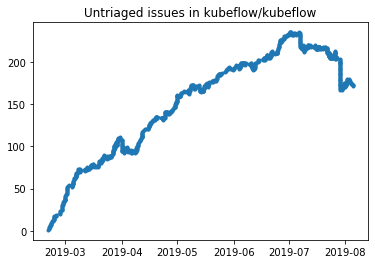

In [256]:
from matplotlib import pylab 
pylab.plot(untriaged.index, untriaged.values, '.-')
pylab.title("Untriaged issues in " + repo)

## Update Needs Triage Kanban board 

* The cells below are used to invoke the code that will update recently updated issues
* If an issue needs triage it is added to the [Needs Triage Kanban board](https://github.com/orgs/kubeflow/projects/26)
* If an issue in the [Needs Triage Kanban board](https://github.com/orgs/kubeflow/projects/26) has been triaged it is removed from the kanban board

In [252]:
importlib.reload(triage)
triager=triage.IssueTriage()

In [257]:
repo="kubeflow/kubeflow"

today = datetime.datetime.now()
today = datetime.datetime(year=today.year, month=today.month, day=today.day)

start_time = today - datetime.timedelta(weeks=4)

issue_filter = {
    "since": start_time.isoformat(),
}
triager.triage(repo, issue_filter=issue_filter)

INFO:root:kubeflow/kubeflow has a total of 1100 issues
INFO:root:Processing shard 0
INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/11:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/12:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/17:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/20:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/31:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/32:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/51:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/52:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/54:
state:Issue doesn't need attention.

INFO:ro

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/640:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/651:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/658:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/668:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/675:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/677:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/681:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/700:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/712:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/716:
state:Issue doesn

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/1277:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/1278:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/1288:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/1291:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/1294:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/1295:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/1299:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/1303:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/1314:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/1316:
state:I

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/1662:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/1668:
state:Issue needs triage:
	 Issue needs one of the labels ['improvement/enhancement', 'community/question', 'kind/bug']

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/1668 already in triage project
INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/1673:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/1678:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/1679:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/1698:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/1706:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/1710:
state:Issue doesn't need attention.

I

INFO:root:Processing shard 3
INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2136:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2140:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2141:
state:Issue needs triage:
	 Issue needs one of the labels ['improvement/enhancement', 'community/question', 'kind/bug']
	 Issue needs an area label

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2141 already in triage project
INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2142:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2144:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2146:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2152:
state:Issue needs triage:
	 Issue needs one of the labels ['improvement/enhancement'

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2377:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2378:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2379:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2381:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2383:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2387:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2388:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2390:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2391:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2392:
state:I

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2545:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2546:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2549:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2550:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2551:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2554:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2559:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2560:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2561:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2562:
state:I

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2682 already in triage project
INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2685:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2686:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2688:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2691:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2693:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2696:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2698:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2699:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2700:
state:Issue doesn't

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2846 already in triage project
INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2847:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2850:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2852:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2857:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2858:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2860:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2861:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2863:
state:Issue needs triage:
	 Issue needs an area label

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2863 al

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2995:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2996:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2997:
state:Issue needs triage:
	 Issue needs one of the priorities ['priority/p0', 'priority/p1', 'priority/p2', 'priority/p3']
	 Issue needs an area label

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2997 already in triage project
INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2998:
state:Issue needs triage:
	 Issue needs one of the labels ['improvement/enhancement', 'community/question', 'kind/bug']

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/2998 already in triage project
INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3000:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3003:
state:Issue doesn't need attention.

I

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3109:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3112:
state:Issue needs triage:
	 Issue needs one of the priorities ['priority/p0', 'priority/p1', 'priority/p2', 'priority/p3']
	 Issue needs an area label

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3112 already in triage project
INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3118:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3120:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3122:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3128:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3129:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3130:
state:I

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3218:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3219:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3220:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3221:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3222:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3223:
state:Issue needs triage:
	 Issue needs one of the priorities ['priority/p0', 'priority/p1', 'priority/p2', 'priority/p3']
	 Issue needs an area label

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3223 already in triage project
INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3225:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3226:
state:I

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3330:
state:Issue needs triage:
	 Issue needs one of the priorities ['priority/p0', 'priority/p1', 'priority/p2', 'priority/p3']
	 Issue needs an area label

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3330 already in triage project
INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3331:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3332:
state:Issue needs triage:
	 Issue needs one of the priorities ['priority/p0', 'priority/p1', 'priority/p2', 'priority/p3']
	 Issue needs an area label

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3332 already in triage project
INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3333:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3336:
state:Issue needs triage:
	 Issue needs one of the priorities ['priority/p0', 'priority/p1', 'priority/p2', 'p

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3409 already in triage project
INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3410:
state:Issue needs triage:
	 Issue needs one of the priorities ['priority/p0', 'priority/p1', 'priority/p2', 'priority/p3']
	 Issue needs an area label

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3410 already in triage project
INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3411:
state:Issue needs triage:
	 Issue needs one of the priorities ['priority/p0', 'priority/p1', 'priority/p2', 'priority/p3']
	 Issue needs an area label

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3411 already in triage project
INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3414:
state:Issue needs triage:
	 Issue needs one of the priorities ['priority/p0', 'priority/p1', 'priority/p2', 'priority/p3']
	 Issue needs an area label

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3414 already 

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3485:
state:Issue needs triage:
	 Issue needs one of the priorities ['priority/p0', 'priority/p1', 'priority/p2', 'priority/p3']
	 Issue needs an area label

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3485 already in triage project
INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3487:
state:Issue needs triage:
	 Issue needs one of the priorities ['priority/p0', 'priority/p1', 'priority/p2', 'priority/p3']
	 Issue needs an area label

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3487 already in triage project
INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3489:
state:Issue needs triage:
	 Issue needs one of the priorities ['priority/p0', 'priority/p1', 'priority/p2', 'priority/p3']
	 Issue needs an area label

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3489 already in triage project
INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3490:
state:I

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3549 already in triage project
INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3550:
state:Issue needs triage:
	 Issue needs one of the priorities ['priority/p0', 'priority/p1', 'priority/p2', 'priority/p3']
	 Issue needs an area label

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3550 already in triage project
INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3552:
state:Issue needs triage:
	 Issue needs one of the priorities ['priority/p0', 'priority/p1', 'priority/p2', 'priority/p3']
	 Issue needs an area label

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3552 already in triage project
INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3553:
state:Issue needs triage:
	 Issue needs an area label

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3553 already in triage project
INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3554:
state:Issue d

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3615 already in triage project
INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3616:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3617:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3618:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3619:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3620:
state:Issue needs triage:
	 Issue needs one of the priorities ['priority/p0', 'priority/p1', 'priority/p2', 'priority/p3']

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3620 already in triage project
INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3623:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3624:
state:Issue doesn't need attention.

INFO:root:

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3722:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3723:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3724:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3725:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3726:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3727:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3728:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3733:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3735:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3736:
state:I

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3803 already in triage project
INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3804:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3804 remove from triage project
INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3805:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3805 remove from triage project
INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3806:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3807:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3807 remove from triage project
INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3808:
state:Issue doesn't need attention.

INFO:root:Issue https://github.com/kubeflow/kubeflow/issues/3808 remove from triage project
INFO:root:Issue https://gi

## Fetch Card Id

* This is a snipped which is useful for getting the id of a project card.
* We use it to fetch the card id that triage.py should add issues needing triage to.

In [254]:
project_query="""query projectCards($org: String!, $project: String!) {
  organization(login: $org) {
    projects(last: 1, search: $project) {
      totalCount
      edges {
        node {
          name
          url
          columns(first: 20) {
            totalCount
            pageInfo {
              endCursor
              hasNextPage
            }
            nodes {
              name
              id
            }
          }
        }
      }
    }
  }
}

"""
variables = {
    "org": "kubeflow",
    "project": "Bug Triage",
}
results = client.run_query(project_query, variables)
results

{'data': {'organization': {'projects': {'totalCount': 0, 'edges': []}}}}